In [1]:
import pyspark 
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf, SparkContext
import os
import re
import numpy as np
import time
from functools import reduce
import pyspark.sql.functions as F
import pyspark.sql.functions as f

from pyspark.sql.types import FloatType, StringType, IntegerType
from pyspark.sql.window import Window

Location_master = 'spark://linux:7077'
Location_master = 'local'
try:
    sparkSession.stop()
except:
    pass
sparkSession = SparkSession \
    .builder \
    .master(Location_master)\
    .appName("Phan tich 2020") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.executor.memory", "4g") \
    .config('spark.cores.max','4')\
    .getOrCreate()

In [2]:
# defaut
font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 12,
        }

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
plt.style.use(
    'ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

In [4]:
data = sparkSession.read.csv("../../../Data_process/Diemthi2021.csv", header=True)
print(data.count())
data.printSchema()
data.show(5)

988013
root
 |-- SBD: string (nullable = true)
 |-- Toan: string (nullable = true)
 |-- Ngu_van: string (nullable = true)
 |-- Ngoai_ngu: string (nullable = true)
 |-- Vat_ly: string (nullable = true)
 |-- Hoa_hoc: string (nullable = true)
 |-- Sinh_hoc: string (nullable = true)
 |-- Lich_su: string (nullable = true)
 |-- Dia_ly: string (nullable = true)
 |-- GDCD: string (nullable = true)
 |-- Cum_thi: string (nullable = true)

+--------+----+-------+---------+------+-------+--------+-------+------+----+-------+
|     SBD|Toan|Ngu_van|Ngoai_ngu|Vat_ly|Hoa_hoc|Sinh_hoc|Lich_su|Dia_ly|GDCD|Cum_thi|
+--------+----+-------+---------+------+-------+--------+-------+------+----+-------+
|01000001| 2.2|    3.5|     null|  null|   null|    null|    2.5|   5.5|null|     01|
|01000002| 9.2|   8.25|     10.0|  null|   null|    null|   5.75|  9.75|9.25|     01|
|01000003| 4.4|   6.25|     null|  null|   null|    null|   4.25|   4.0|null|     01|
|01000004| 8.4|   6.75|     10.0|   4.0|    3.0|   

In [5]:
data_all = data.withColumn('Toan', F.col('Toan').cast(FloatType()))
data_all = data_all.withColumn('Ngu_van', F.col('Ngu_van').cast(FloatType()))
data_all = data_all.withColumn('Ngoai_ngu', F.col('Ngoai_ngu').cast(FloatType()))
data_all = data_all.withColumn('Vat_ly', F.col('Vat_ly').cast(FloatType()))
data_all = data_all.withColumn('Hoa_hoc', F.col('Hoa_hoc').cast(FloatType()))
data_all = data_all.withColumn('Sinh_hoc', F.col('Sinh_hoc').cast(FloatType()))
data_all = data_all.withColumn('Lich_su', F.col('Lich_su').cast(FloatType()))
data_all = data_all.withColumn('Dia_ly', F.col('Dia_ly').cast(FloatType()))
data_all = data_all.withColumn('GDCD', F.col('GDCD').cast(FloatType()))

data_all.printSchema()

root
 |-- SBD: string (nullable = true)
 |-- Toan: float (nullable = true)
 |-- Ngu_van: float (nullable = true)
 |-- Ngoai_ngu: float (nullable = true)
 |-- Vat_ly: float (nullable = true)
 |-- Hoa_hoc: float (nullable = true)
 |-- Sinh_hoc: float (nullable = true)
 |-- Lich_su: float (nullable = true)
 |-- Dia_ly: float (nullable = true)
 |-- GDCD: float (nullable = true)
 |-- Cum_thi: string (nullable = true)



In [6]:
print(data_all.count())

988013


### Số lượng thí sinh theo tỉnh

In [7]:
count_tinh = data_all.groupBy('Cum_thi').count().alias('So_luong').orderBy('Cum_thi')
count_tinh = count_tinh.withColumn('So_luong', f.col('count')).drop('count').toPandas()

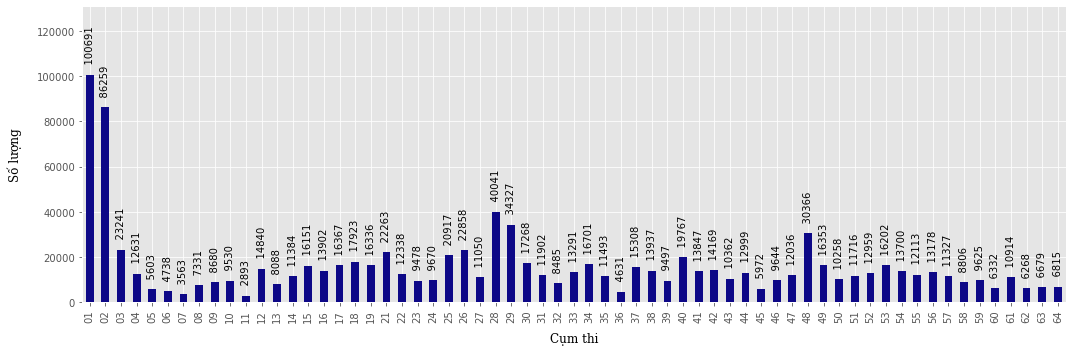

In [8]:
pd.Series(count_tinh["So_luong"].values, count_tinh["Cum_thi"].values).plot(kind = 'bar', colormap='plasma')
# ------show----tung so luong------
for index, value in enumerate(count_tinh['So_luong'].values):
    plt.text(index, value, '    ' + str(value), rotation = 90, 
            horizontalalignment='center', multialignment='center')
plt.ylim(0, count_tinh['So_luong'].values.max()*1.3)
plt.xlabel('Cụm thi', labelpad=10, fontdict=font)
plt.ylabel('Số lượng', labelpad=15, fontdict=font)
plt.tight_layout()
plt.show()

In [9]:
count_tinh.count()

Cum_thi     63
So_luong    63
dtype: int64

### Tính số lượng theo tỉnh

In [11]:
max_tinh = data_all.withColumn('max', f.row_number().over(
    Window.partitionBy("Cum_thi").orderBy(f.col('SBD').desc())
    )).filter('max == 1').select('Cum_thi', 'SBD').orderBy('Cum_thi')

max_tinh =max_tinh.toPandas()

In [12]:
df_tinh = [int(x[2:8]) for x in max_tinh['SBD'].values]
sum(df_tinh)

1019029

In [13]:
len(df_tinh)

63

### Show miss data

In [14]:
data_check = data_all.withColumn('crawl', f.substring(f.col('SBD'), 0, 6)).select('Cum_thi', 'crawl')
data_check = data_check.groupBy('Cum_thi', 'crawl').count().orderBy('Cum_thi', 'crawl')
data_check.show()

+-------+------+-----+
|Cum_thi| crawl|count|
+-------+------+-----+
|     01|010000|   97|
|     01|010001|  100|
|     01|010002|  100|
|     01|010003|  100|
|     01|010004|   98|
|     01|010005|   98|
|     01|010006|   99|
|     01|010007|   99|
|     01|010008|  100|
|     01|010009|   99|
|     01|010010|  100|
|     01|010011|   99|
|     01|010012|   98|
|     01|010013|  100|
|     01|010014|  100|
|     01|010015|  100|
|     01|010016|   98|
|     01|010017|  100|
|     01|010018|  100|
|     01|010019|  100|
+-------+------+-----+
only showing top 20 rows



## Tính điểm các khối

In [15]:
df = data_all.toPandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988013 entries, 0 to 988012
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   SBD        988013 non-null  object 
 1   Toan       977661 non-null  float32
 2   Ngu_van    974732 non-null  float32
 3   Ngoai_ngu  868665 non-null  float32
 4   Vat_ly     345541 non-null  float32
 5   Hoa_hoc    347178 non-null  float32
 6   Sinh_hoc   341745 non-null  float32
 7   Lich_su    634562 non-null  float32
 8   Dia_ly     628715 non-null  float32
 9   GDCD       532168 non-null  float32
 10  Cum_thi    988013 non-null  object 
dtypes: float32(9), object(2)
memory usage: 49.0+ MB


In [16]:
df['KhoiA'] = df['Toan'] + df['Vat_ly'] + df['Hoa_hoc']
df['KhoiB'] = df['Toan'] + df['Sinh_hoc'] + df['Hoa_hoc']
df['KhoiC'] = df['Ngu_van'] + df['Lich_su'] + df['Dia_ly']
df['KhoiA1'] = df['Toan'] + df['Vat_ly'] + df['Ngoai_ngu']
df['KhoiD1'] = df['Toan'] + df['Ngu_van'] + df['Ngoai_ngu']

## Phân tích theo từng môn học

In [17]:
def Draw_MonHoc(save_path, df, mon_hoc, tittle):
    data_show = []
    if('Khoi' in mon_hoc):
#         data_show = round_diem(df[mon_hoc].values)
#         data_show = pd.Series(data_show).value_counts().sort_index(ascending=True)
        bins = [x/2.0 for x in range(0, 30*2+1)]
        
        data_show = df[mon_hoc].value_counts(bins = bins).sort_index(ascending=True)
    elif(mon_hoc == 'Ngu_van'):
        data_show = df[mon_hoc].value_counts(bins = 40).sort_index(ascending=True)
    else:
        data_show = df[mon_hoc].value_counts().sort_index(ascending=True)
        x_list = [str(round(x, 2)) for x in data_show.index]
        y_list = data_show.values
        data_show = pd.Series(y_list, x_list)
    # ------show----tung so luong------
    for index, value in enumerate(data_show.values):
        plt.text(index, value, '    ' + str(value), rotation = 90, 
                 horizontalalignment='center', multialignment='center')
    data_show.plot(kind='bar', colormap='plasma')
    
    # ---- design ----
    font = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 12,
            }
    font_title = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 16,
            }
    
    plt.grid(c='white', linewidth=2, fillstyle='full', b=True)
    plt.ylim(0, data_show.values.max()*1.4)
    plt.xlabel('Điểm', labelpad=10, fontdict=font)
    plt.ylabel('Số lượng', labelpad=15, fontdict=font)

    plt.title(tittle, fontdict=font_title)
    plt.tight_layout()
    plt.savefig(save_path + mon_hoc +'.png', dpi=100, pad_inches=0.0)
    plt.show()
    return

### Hàm làm tròn điểm

In [18]:
def round_diem(list_diem):
    rs = []
    for diem in list_diem:
        diem = str(round(diem, 2))
        vitri_dauphay = diem.find('.')
        phandu = 0
        if(vitri_dauphay == -1):
            phandu == 0
            rs.append(float(diem))
            continue
        elif(vitri_dauphay == len(diem)-2):
            phandu = int(diem[vitri_dauphay+1])*10
        else:
            phandu = int(diem[vitri_dauphay+1])*10 + int(diem[vitri_dauphay+2])
            
        #---bat dau lam tron---
        diem_nho = 0
        if(phandu < 25):
            phandu = 0 if (2*phandu < 25) else 25
        elif(phandu < 50):
            phandu = 25 if((phandu-25)<(50-phandu)) else 50
        elif(phandu < 75):
            phandu = 50 if((phandu-50)<(75-phandu)) else 75
        else:
            phandu = 75 if((phandu-75)<(100-phandu)) else 0
            diem_nho = 0 if(phandu == 75) else 1
        phan_nguyen, _= diem.split('.')
        rs.append(float(str(int(phan_nguyen)+diem_nho) + '.' + str(phandu)))
    return rs

In [19]:
ma_Monhoc = [
    {'Mon_hoc':'Toan', 'Ten': 'Toán'},
    {'Mon_hoc':'Ngu_van', 'Ten': 'Ngữ Văn'},
    {'Mon_hoc':'Ngoai_ngu', 'Ten': 'Tiếng Anh'},
    {'Mon_hoc':'Hoa_hoc', 'Ten': 'Hóa học'},
    {'Mon_hoc':'Sinh_hoc', 'Ten': 'Sinh hoc'},
    {'Mon_hoc':'Vat_ly', 'Ten': 'Vật lý'},
    {'Mon_hoc':'Lich_su', 'Ten': 'Lịch sử'},
    {'Mon_hoc':'Dia_ly', 'Ten': 'Địa lý'},
    {'Mon_hoc':'GDCD', 'Ten': 'Giáo dục công dân'},
    {'Mon_hoc':'KhoiA', 'Ten': 'Khối A'},
    {'Mon_hoc':'KhoiB', 'Ten': 'Khối B'},
    {'Mon_hoc':'KhoiC', 'Ten': 'Khối C'},
    {'Mon_hoc':'KhoiD1', 'Ten': 'Khối D1'},
    {'Mon_hoc':'KhoiA1', 'Ten': 'Khối A1'},
]
# ma_Monhoc = pd.DataFrame(ma_Monhoc)

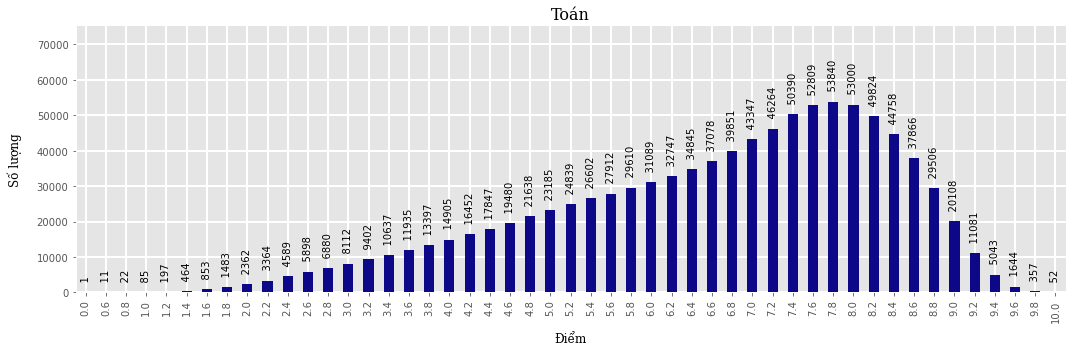

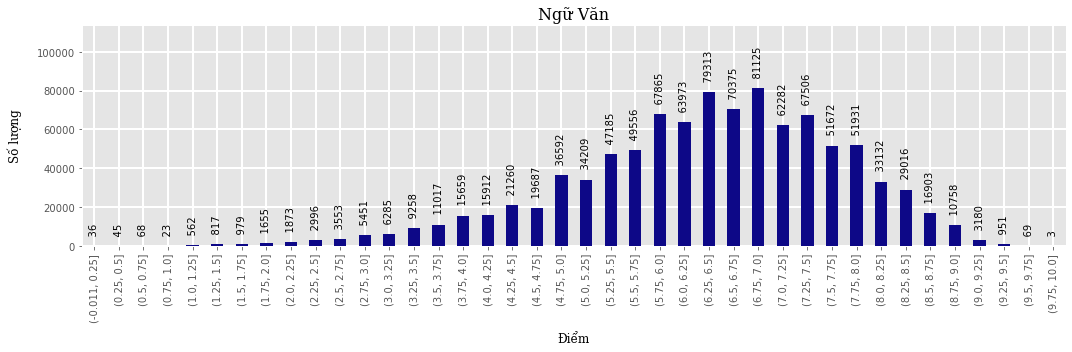

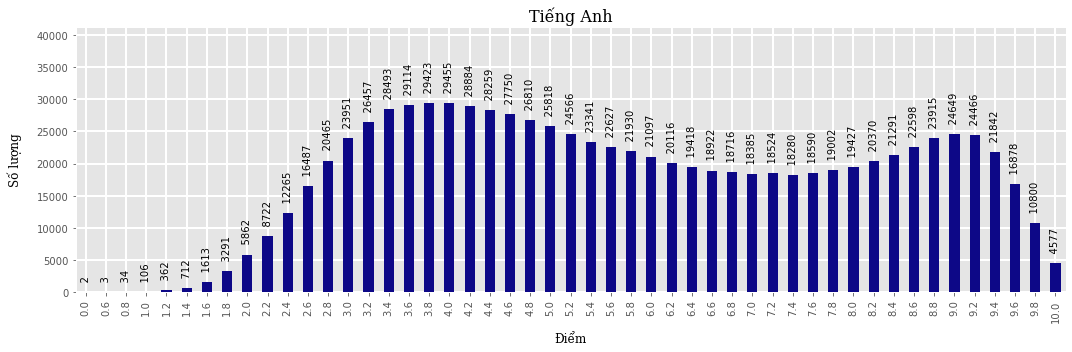

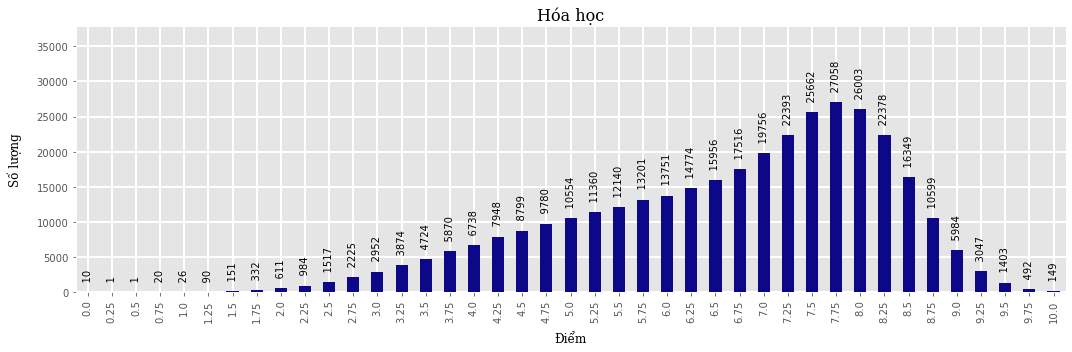

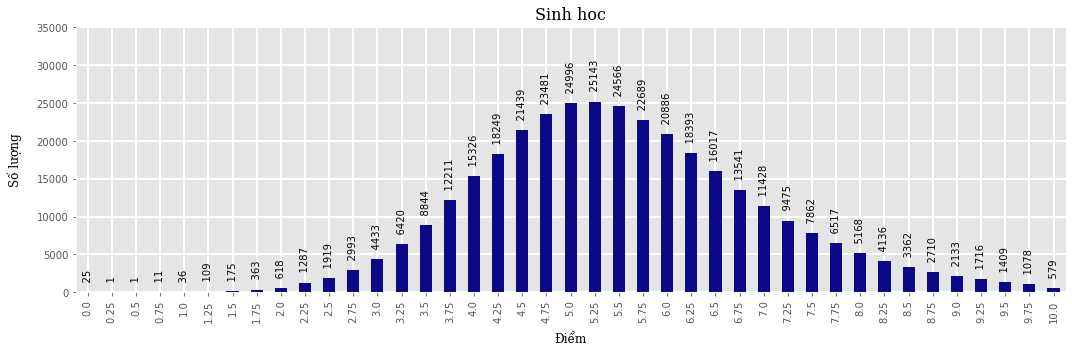

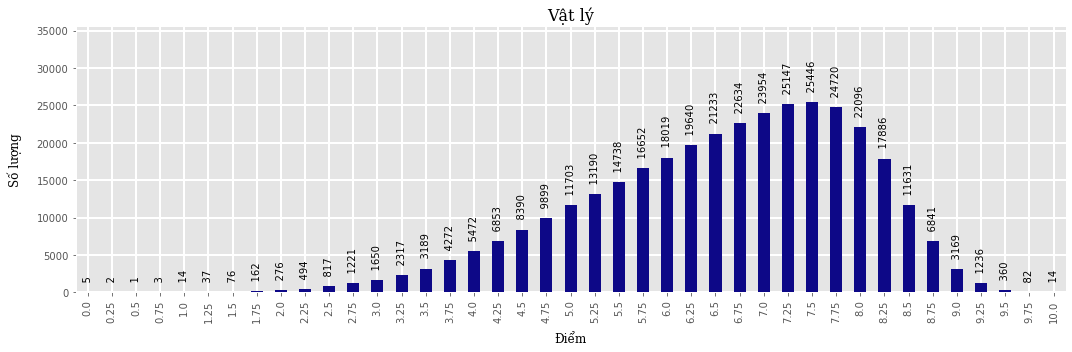

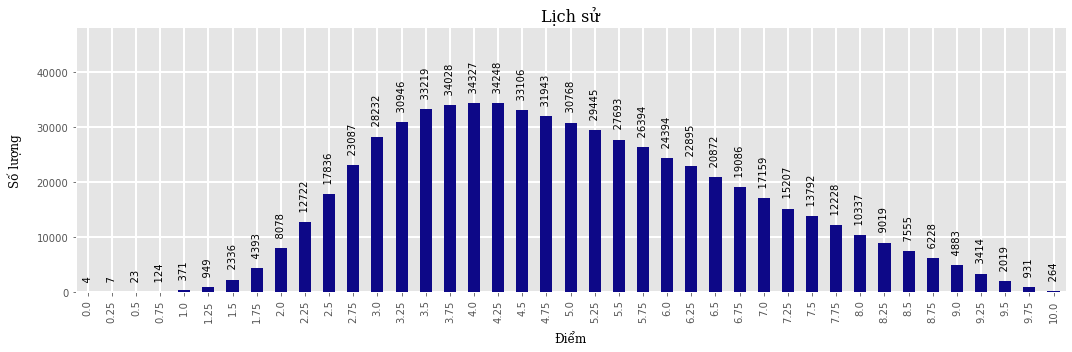

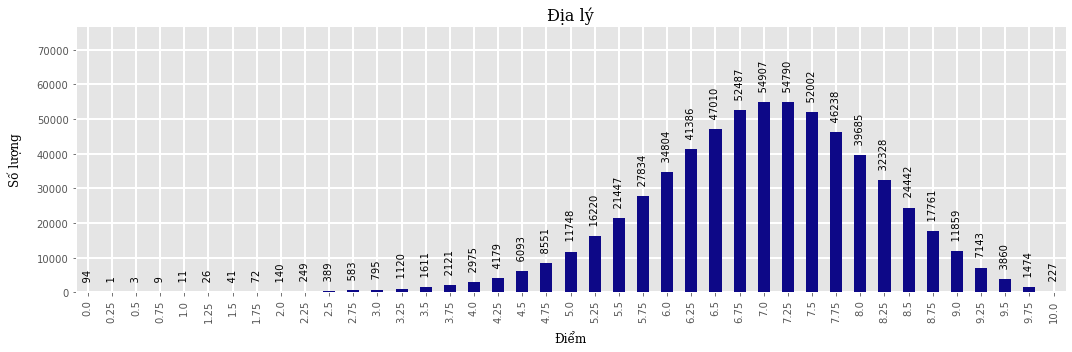

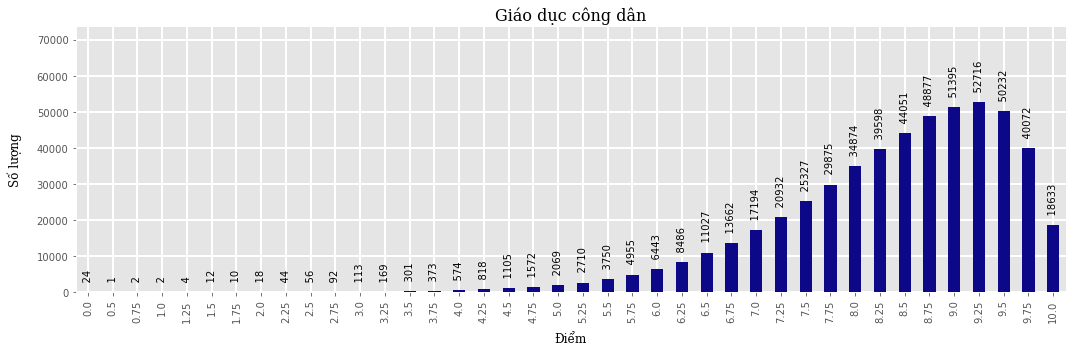

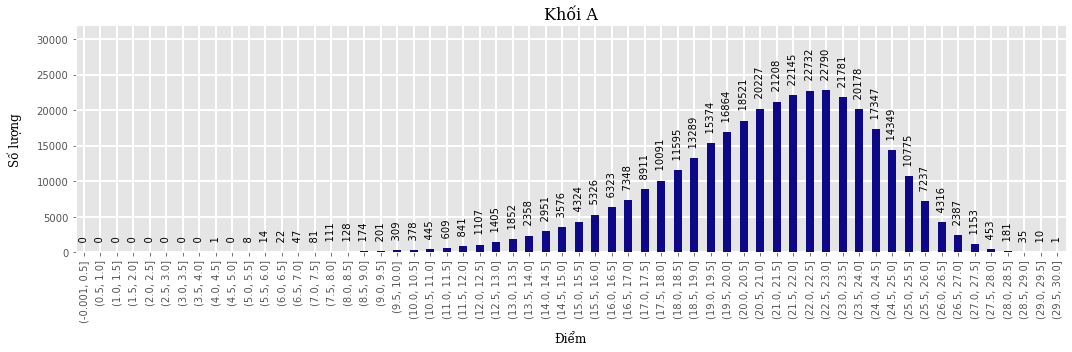

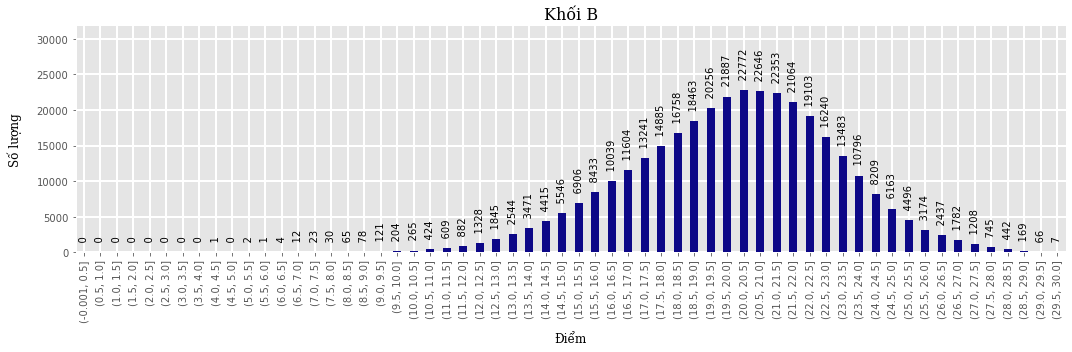

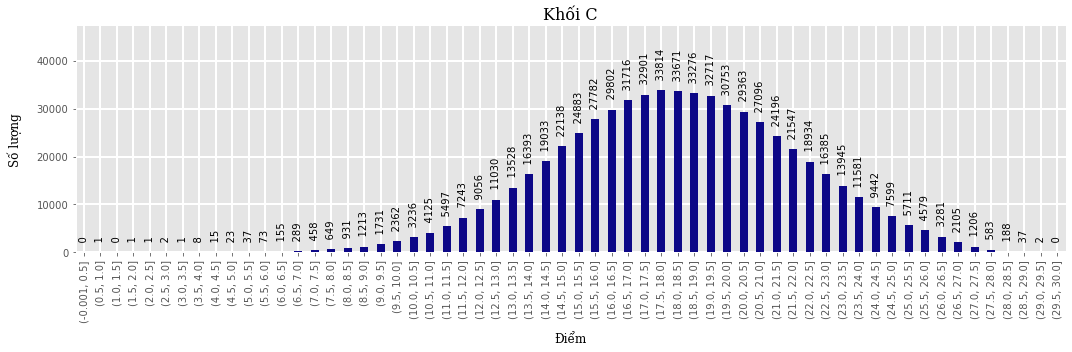

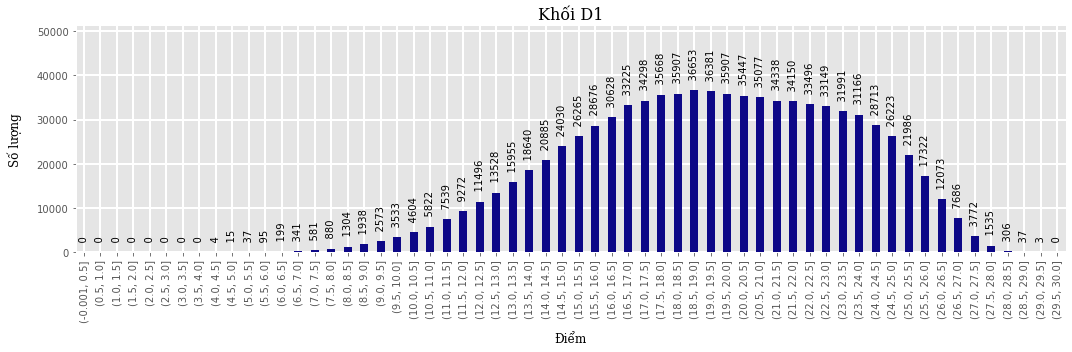

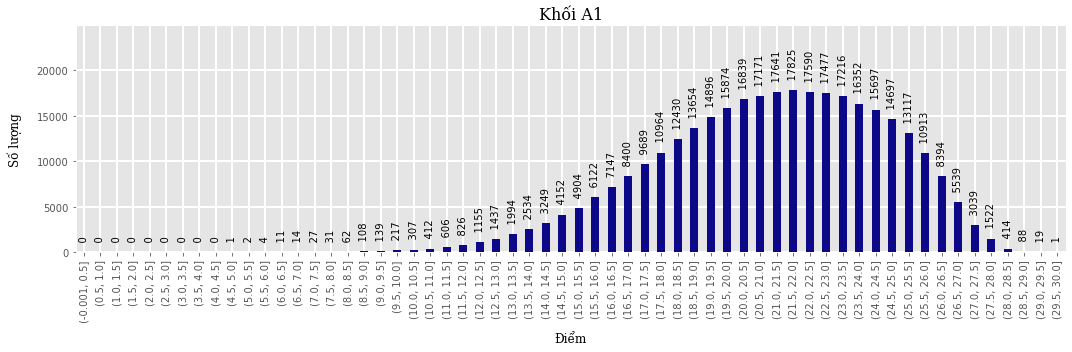

In [20]:
save_path = "../Phổ điểm/"

for node in ma_Monhoc:
    Draw_MonHoc(save_path, df, node['Mon_hoc'], node['Ten'])

In [21]:
# sparkSession.stop()